In [1]:
import numpy as np
import pandas as pd
# import pickle
import cPickle as pickle

import gzip

# from joblib import Parallel, delayed
# import multiprocessing
from methods.index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec

import bisect
from scipy import interpolate

from joblib import Parallel, delayed
import multiprocessing

from scipy import stats
from methods.xflib import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')
from scipy.integrate import nquad

from methods.GLD_file_tools import GLD_file_tools

from methods.precip_model import precip_model, build_database

# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

#### This version for multiple energy bands:

In [ ]:
## Load precalculated stencils:
suffix = 'AE8MAX_flux_0' # ae8max,
#suffix = 'AE8MAX_flux_1' # bell model
# suffix = 'AE8MAX_flux_2' # propensity
# suffix = 'AE8MIN_flux_0' # ae8minx
nb = 64
with open('../outputs/precip_dbs/precalculated_stencils_%s_%db.pkl'%(suffix, nb),'rb') as file:
    precalc_stencils = pickle.load(file)

with open('../outputs/precip_dbs/nightside_%s_%db.pkl'%(suffix, nb),'rb') as file:
    db = pickle.load(file)

In [3]:
# Get Kp data
Ktimes, Kp_arr = load_Kp()
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp_arr = np.array(Kp_arr)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp_arr[0:-8],Kp_arr[1:-7],Kp_arr[2:-6], Kp_arr[3:-5],
                Kp_arr[4:-4],Kp_arr[5:-3],Kp_arr[6:-2], Kp_arr[7:-1], Kp_arr[8:]],axis=0)
Kpmtimes = Ktimes[8:]


unique_Kpm = np.unique(Kpmax)
# print unique_Kpm

In [4]:
# Get energy vector (just loading from a file instead of calculating it here)
with gzip.open('/shared/users/asousa/WIPP/WIPP_stencils/outputs/stencils/nightside/stencil_30f_0.2L/kp0/phi_inlat_15_AE8MAX_flux_0.pklz','rb') as file:
    data = pickle.load(file)

E = data['params']['E_tot_arr']

Q_NH Q_SH
0.000374189072096 -1.26793538577e-06
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band 45
band 46
band 47
band 48
band 49
band 50
band 51
band 52
band 53
band 54
band 55
band 56
band 57
band 58
band 59
band 60
band 61
band 62
band 63
Q_NH Q_SH
5.05189393391e-05 -2.92436166405e-07
multi band interpolators
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band

IndexError: index 9 is out of bounds for axis 1 with size 9

In [ ]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 0.5
sec_in_year = 60*60*24*365.25

data_path = '../../lightning_power_study/outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

unique_kp = [0.,0.3,0.7, 1.,1.3, 1.7, 2.,2.3, 2.7, 3., 3.3, 3.7, 4., 4.3, 4.7,5.,5.3,5.7,6.,6.3,6.7,7.,7.3,7.7,8.]
inlats = np.arange(15, 56, 1) 
stencil_lats = np.hstack([np.arange(-90, -20,0.5),(np.arange(19.5,90,0.5))])
stencil_lons = np.linspace(-14, 14, 57)

cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(stencil_lats) + dlat/2.0)*D2R))

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()

# Set up grid:
gridlons = np.arange(-180, 180, 0.5)
gridlats = stencil_lats #np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])
dlat=0.5
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))





cur_map_total = np.zeros([180, 360])
count=0
counts = dict()


n_bands = 64

dtvec = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in files]

starttime = datetime.datetime(2015,1,1,0,0,0)
stoptime =   datetime.datetime(2016,1,1,0,0,0)

times_todo = sorted([x for x in dtvec if x >= starttime and x < stoptime])
total_files = len(times_todo)



for f_ind, filetime in enumerate(times_todo):
    print "loading %d/%d"%(f_ind, total_files)
    filename = filetime.strftime('%m_%d_%Y_%H_%M') + '.pklz'
    print filename
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')

        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']

        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(np.abs(cur_map) > 0)
        
        
        outkey = int(np.round(10.*Kpm))        
        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        
        count += 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
#             print x, y
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(cur_map_lats[x])))
        
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
#             print key
#             key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
#             outkey = (cur_mlt, int(np.round(10.*Kpm)))
            outkey = cur_mlt
#             # this version to just do average day + night
#             outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key].swapaxes(0,1)*I

                # Add to respective map:
                lonleft  = int(y*2 - len(stencil_lons)/2 - 1)
                lonright = int(y*2 + len(stencil_lons)/2)
                
#                 print lonleft, lonright
#                 print gridlons[lonleft], gridlons[lonright]
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(gridlons), len(gridlats), n_bands])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:,:] += \
                            stencil[0:np.abs(lonleft),:,:]

                elif lonright > len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :,:]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :,:] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
#     pwr_maps[k] *= period_factor/counts[k[1]]
#     pwr_maps[k] /= counts[k]   # Average over each 3-hour frame
    pwr_maps[k] /= count   # Average over each 3-hour frame
    pwr_maps[k] /= file_duration  # Total precip -> counts/cm^2/sec
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100

In [ ]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 0.5
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))
cell_areas_lightning = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(np.arange(-90,90,0.5)) + 0.25)*D2R))



# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 9
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [0, 10]


band_index = 20

fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])

print np.shape(gridlons)
print np.shape(gridlats)
print np.shape(pwr_maps[0][:])

print np.min(pwr_maps[0]), np.max(pwr_maps[0])
p0 = ax[0].pcolormesh(gridlons, gridlats, pwr_maps[0][:,:,band_index].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
p1 = ax[1].pcolormesh(gridlons, gridlats, pwr_maps[12][:,:,band_index].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
ax[0].set_ylim([-70,70])
ax[1].set_ylim([-70,70])

twinx0 = ax[0].twinx()
twinx0.set_ylim([-70,70])
# twinx0.set_xticks([])
ytix = np.array([-65,-45,-25, 25,45,65])
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
ytix_L_labels = ['%.1f'%z for z in ytix_L]
twinx0.set_yticks(ytix)
twinx0.set_yticklabels(ytix_L_labels)


# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Electron Average Number Flux \n[#/cm$^2$/ev/sec]') 


cmt = cur_map_total/(f_ind + 1)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas_lightning[np.newaxis,:]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

clims2 = [-8, -3]
# print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolorfast(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-70, 70])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 


ax[0].set_xticks([])
ax[0].set_ylabel('Night\nLatitude (magnetic)')
ax[1].set_ylabel('Day\nLatitude (magnetic)')
ax[1].set_xticks([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')

ax[0].set_title('Average electon flux at ionosphere')
gs.tight_layout(fig)

# fig.savefig('Energy_density_daynite.png',dpi=300)

In [ ]:
# Find total spectrum vs latitude:
# Plot spectral density vs L-shell over the US:
flux_vs_lat = dict()

lonlims = [-50, 10]  # ~ approximately over the US
lonlims = [-180, 180]  # ~ approximately over the US
clims = [-8, 4]
left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

latlims = [-70, 70]
grid_E = []
for (p1, p2) in db['band_pairs']:
    grid_E.append((E[np.round((p1 + p2)/2)]))
#     print "fuck"

grid_E = np.array(grid_E)

E_min = 1e3
E_max = 1e8



print np.shape(pwr_maps_linear[0])
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    flux_vs_lat[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    flux_vs_lat[k] = np.log10(flux_vs_lat[k])
    flux_vs_lat[k][np.isinf(flux_vs_lat[k])] = -100

    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
cax = plt.subplot(gs[0:2,1])

# # Find maximum value across all keys:
# mv = -100
# for k in flux_vs_lat.keys():
#     if np.max(flux_vs_lat[k]) > mv:
#         mv = np.max(flux_vs_lat[k])
mv = 0

for ind, k in enumerate(flux_vs_lat.keys()):
    # upsample for smoothness of plotting:
    print np.shape(flux_vs_lat[k])
    pinterp = interpolate.RegularGridInterpolator([gridlats, grid_E], flux_vs_lat[k] , bounds_error=False, fill_value=-100)
    px, py = np.meshgrid(gridlats, E)
    pts = zip(px.ravel(), py.ravel())
    
    D_interp = pinterp(pts).reshape(len(E), len(gridlats)).T
    print np.shape(D_interp)
    
    p = ax[ind].pcolormesh(E, gridlats, D_interp, vmin = clims[0], vmax=clims[1], cmap = plt.get_cmap('jet'))
    
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')

    ax[ind].set_ylim(latlims)
    twinx0 = ax[ind].twinx()
    twinx0.set_ylim(latlims)
    # twinx0.set_xticks([])
    ytix = np.array([-65,-45,-25, 25,45,65])
    ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
    ytix_L_labels = ['%.1f'%z for z in ytix_L]
    twinx0.set_yticks(ytix)
    twinx0.set_yticklabels(ytix_L_labels)


    print np.min(flux_vs_lat[k]), np.max(flux_vs_lat[k])
ax[0].set_xticks([])
ax[0].set_ylabel('Latitude\nNightside')
ax[-1].set_ylabel('Latitude\nDayside')
ax[-1].set_xlabel('Energy [ev]')

ax[0].set_xscale("log", nonposx='clip')
ax[1].set_xscale("log", nonposx='clip')


# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Flux spectral density [mErg/cm$^2$/sec/ev]') 
# cb.set_label('Normalized scattering propensity [max(#)/cm$^2$/sec/ev]') 
# cb.set_label('scattering propensity (relative to max)\n[mErg/cm$^2$/sec/ev/max]') 


# ax[0].set_title('Global Average Lightning Spectra vs Field Line')

fig.subplots_adjust(right=0.8)
ax[0].set_xlim([2e1, 1e8])
ax[1].set_xlim([2e1, 1e8])

ax[0].set_xticks([])
gs.tight_layout(fig)


# fig.savefig('scattering_propensity_energy_vs_latitude.png',dpi=150)

In [ ]:
d = os.listdir(data_path)
files  = [x for x in d if x.endswith('.pklz')]
years  = np.unique(np.array([int(x.split('_')[2]) for x in files]))
months = np.unique(np.array([int(x.split('_')[0]) for x in files]))
days   = np.unique(np.array([int(x.split('_')[1]) for x in files]))
hours  = np.unique(np.array([int(x.split('_')[3]) for x in files])) 
print years
print months
print days
print hours



In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(dtvec, np.ones_like(dtvec),'x')

## Try single-machine parallelization (shared memory):

In [118]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25

num_cores = multiprocessing.cpu_count()


data_path = '../../lightning_power_study/outputs/GLDstats_v7/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

# Sort by day (~ 8 entries per day)
daydict = dict()
for t in intimes:
    if not daydict.has_key(t.date()):
        daydict[t.date()] = []
    daydict[t.date()].append(t)


unique_kp = [0.,0.3,0.7, 1.,1.3, 1.7, 2.,2.3, 2.7, 3., 3.3, 3.7, 4., 4.3, 4.7,5.,5.3,5.7,6.,6.3,6.7,7.,7.3,7.7,8.]
inlats = np.arange(15, 56, 1) 
stencil_lats = np.hstack([np.arange(-90, -20,dlat),(np.arange(19.5,90,dlat))])
stencil_lons = np.linspace(-14, 14, 14*2/dlon + 1)

# cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(stencil_lats) + dlat/2.0)*D2R))

cur_map_lats = np.arange(-90, 90)
# stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
# period_factor = stencil_duration/file_duration



# Set up grid:
gridlons = np.arange(-180, 180, dlon)
gridlats = stencil_lats #np.arange(-90, 90, 0.5)
# pwr_map = np.zeros([len(gridlons), len(gridlats)])
# dlat=0.5
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))





cur_map_total = np.zeros([180, 360])
count=0
counts = dict()


n_bands = 64

dtvec = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in files]

starttime = datetime.datetime(2015,1,1,0,0,0)
stoptime =   datetime.datetime(2016,1,1,0,0,0)

times_todo = sorted([x for x in dtvec if x >= starttime and x < stoptime])
total_files = len(times_todo)

out_path = '../outputs/precip_dbs/precip_calcs'

if not os.path.exists(out_path):
    os.mkdir(out_path)
    
def job(tlist):
#     print "loading %d/%d"%(f_ind, total_files)
    print "doing day ", tlist[0].date()
    pwr_map = np.zeros([len(gridlons), len(gridlats), n_bands])
    
    cur_map_total = np.zeros([180, 360])
    for filetime in tlist:
#         filetime = times_todo[t]
        filename = filetime.strftime('%m_%d_%Y_%H_%M') + '.pklz'

        
#         print filename
        with gzip.open(os.path.join(data_path, filename)) as f:
            thingy = pickle.load(f)
            intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')

            # Get current Kpmax
            Kpm_index = bisect.bisect_left(Kpmtimes, intime)
            Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
#             print Kpm
            # Load squared current map:
            cur_map = thingy['cur_map']

            cur_map_total += cur_map
            # Select day and night bins:
            mltvec = xf.lon2MLT(intime, gridlons)
            mltvec_quantized = np.zeros_like(gridlons)
            mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12


            # Loop through each cell in the input current map, interpolate and add
            todo = np.where(np.abs(cur_map) > 0)

            for x,y in zip(todo[0], todo[1]):
                I = cur_map[x,y] # squared input current
    #             print x, y
                # Absolute value on latitude, since we're assuming model is symmetric North / South
                cur_mlt = int(mltvec_quantized[y])
                cur_lat = int(np.abs(np.round(cur_map_lats[x])))

                key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
            
                if precalc_stencils.has_key(key):
                    stencil = precalc_stencils[key].swapaxes(0,1)*I
                    print np.shape(stencil)
                    # Add to respective map:
                    lonleft  = int(y - len(stencil_lons) - 1)
                    lonright = int(y + len(stencil_lons))

                    if lonleft < 0:
                        # wrap left
                        pwr_map[0:lonright,: ]+= stencil[np.abs(lonleft):,:,:]
                        pwr_map[(len(gridlons) - np.abs(lonleft)):,:,:] += \
                                stencil[0:np.abs(lonleft),:,:]

                    elif lonright > len(gridlons):
                        # wrap right
                        pwr_map[lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :,:]
                        pwr_map[0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:,:]

                    else:
                        # Middle
                        pwr_map[lonleft:lonright, :,:] += stencil


    outdict = dict()
    outdict['flux'] = pwr_map
    outdict['cur_map'] = cur_map_total
    
#     out_filename = 'flux_' + filetime.strftime('%m_%d_%Y_%H') + '.pklz'
    out_filename = 'flux_' + tlist[0].strftime('%Y_%m_%d') + '.pklz'

    with gzip.open(os.path.join(out_path, out_filename),'wb') as file:
        pickle.dump(outdict, file, protocol=pickle.HIGHEST_PROTOCOL)
    
#     return pwr_map

# ret = Parallel(n_jobs=num_cores)(delayed(job)(t) for t in range(len(times_todo[0:24])))
# ret = Parallel(n_jobs=num_cores)(delayed(job)(tlist) for tlist in daydict.values()[0:8])
job(daydict.values()[0])


doing day  2014-11-24
(57, 281, 64)


ValueError: operands could not be broadcast together with shapes (59,141,64) (57,281,64) (59,141,64) 

In [32]:
tlist = daydict.values()[0]
out_filename = 'flux_' + tlist[0].strftime('%Y_%m_%d') + '.pklz'
print out_filename


flux_2014_11_24.pklz


In [11]:
print np.shape(d['flux'])

(720, 281, 64)


In [5]:
suffix = 'AE8MAX_flux_0'
nb = 64
with open('../outputs/precip_dbs/nightside_%s_%db.pkl'%(suffix, nb),'rb') as file:
    db = pickle.load(file)

band_pairs = db['band_pairs']
E_vec = db['E_vec']

In [5]:
with gzip.open('../outputs/seasonal_precip/energy_AE8MAX_flux_0/flux_2015_11_01.pklz','rb') as file:
    d = pickle.load(file)
    
dlat = 1
dlon = 1
stencil_lats = np.hstack([np.arange(-80, -19,dlat),(np.arange(20,80 + dlat,dlat))])
stencil_lons = np.linspace(-14, 14, int(14*2./dlon) + 1)
n_bands = 64
mode = 'energy'
logscale = False
dlon = np.abs(stencil_lons[1] - stencil_lons[0])
dlat = np.abs(stencil_lats[1] - stencil_lats[0])
gridlons = np.arange(-180, 180, dlon)
gridlats = stencil_lats

(360, 122, 64)


<IPython.core.display.Javascript object>


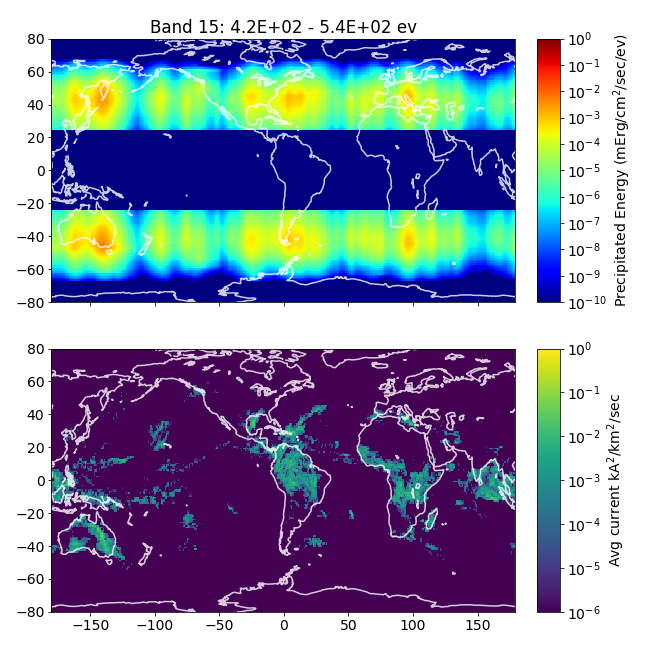

-inf -2.2502552402
-100.0 -1.46519203581


In [16]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.





# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

file_duration = datetime.timedelta(hours=24).total_seconds()


print np.shape(d['flux'])

fig, ax = plt.subplots(2,2, sharex='col', gridspec_kw={'width_ratios': [1, 0.05]})

band_index = 15

clims = [-10,0]
pdat = np.log10(d['flux'][:,:,band_index].T)
print np.min(pdat), np.max(pdat)
p0 = ax[0,0].pcolormesh(gridlons, gridlats, pdat, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))
ax[0,0].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[0,0].set_xlim([-180,179])
ax[0,0].set_ylim([-80, 80])

cb = plt.colorbar(p0, cax=ax[0,1])
cb.set_label('Precipitated Energy (mErg/cm$^2$/sec/ev)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)

cmt = d['cur_map']

cmt = cmt # Arrives from precip_seasonal_parallel as A^2/sec
# cmt  = cmt / 8
# cmt *= sec_in_year
cmt = cmt/(1000.*1000.)
cell_areas_1deg = np.abs((R_E*D2R)*(R_E*D2R)*np.cos((np.arange(-90,90) + dlat)*D2R))


cmt = cmt / cell_areas_1deg[:,np.newaxis]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100
print np.min(cmt), np.max(cmt)


clims2 = [-6, 0]


p1 = ax[1,0].pcolormesh(np.arange(-180,180), np.arange(-90,90),cmt,
                        vmin=clims2[0], vmax=clims2[1], cmap=plt.get_cmap('viridis'))
ax[1,0].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[1,0].set_ylim([-80,80])
cb2 = plt.colorbar(p1, cax=ax[1,1])
cb2.set_label('Avg current kA$^2$/km$^2$/sec')
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)

ax[0,0].set_title('Band %d: %1.1E - %1.1E ev'%(band_index, E_vec[band_pairs[band_index][0]], E_vec[band_pairs[band_index][1]]))
fig.tight_layout()

# ax[0,].set_ylim([-80,80])


In [107]:
dlat = 1
dlon = 1
stencil_lats = np.hstack([np.arange(-80, -19,dlat),(np.arange(20,80 + dlat,dlat))])
stencil_lons = np.linspace(-14, 14, 14*2/dlon + 1)
print stencil_lats

[-80.  -79.5 -79.  -78.5 -78.  -77.5 -77.  -76.5 -76.  -75.5 -75.  -74.5
 -74.  -73.5 -73.  -72.5 -72.  -71.5 -71.  -70.5 -70.  -69.5 -69.  -68.5
 -68.  -67.5 -67.  -66.5 -66.  -65.5 -65.  -64.5 -64.  -63.5 -63.  -62.5
 -62.  -61.5 -61.  -60.5 -60.  -59.5 -59.  -58.5 -58.  -57.5 -57.  -56.5
 -56.  -55.5 -55.  -54.5 -54.  -53.5 -53.  -52.5 -52.  -51.5 -51.  -50.5
 -50.  -49.5 -49.  -48.5 -48.  -47.5 -47.  -46.5 -46.  -45.5 -45.  -44.5
 -44.  -43.5 -43.  -42.5 -42.  -41.5 -41.  -40.5 -40.  -39.5 -39.  -38.5
 -38.  -37.5 -37.  -36.5 -36.  -35.5 -35.  -34.5 -34.  -33.5 -33.  -32.5
 -32.  -31.5 -31.  -30.5 -30.  -29.5 -29.  -28.5 -28.  -27.5 -27.  -26.5
 -26.  -25.5 -25.  -24.5 -24.  -23.5 -23.  -22.5 -22.  -21.5 -21.  -20.5
 -20.  -19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.   24.5
  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.   30.5
  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.   36.5
  37.   37.5  38.   38.5  39.   39.5  40.   40.5  4

In [120]:
print len(stencil_lats), len(stencil_lons)

141 29


In [148]:
cur_lon = 15

lonleft  = int((cur_lon + stencil_lons[0])/dlon + len(gridlons)/2)
lonright = int((cur_lon + stencil_lons[-1])/dlon + len(gridlons)/2) + 1

print lonleft, lonright
print gridlons[lonleft], gridlons[lonright]
print lonright - lonleft

362 419
1.0 29.5
57


<IPython.core.display.Javascript object>


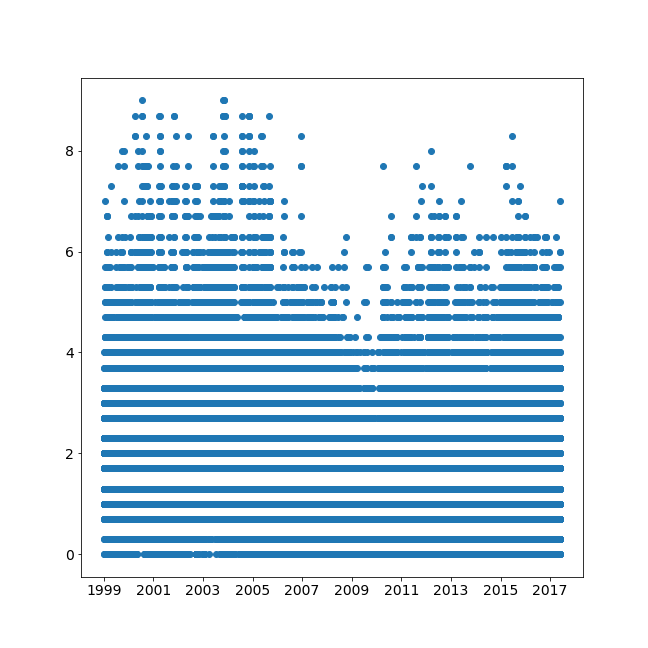

In [223]:
from methods.index_helpers import load_Kp

ktimes, kvals = load_Kp()
plt.figure()
plt.plot(ktimes, kvals,'o')

### Seasonal studies -- analyze results from precip_seasonal_parallel.py

In [110]:
mode = 'energy'
# suffix = 'AE8MAX_flux_0'
# suffix = 'AE8MIN_flux_0'
suffix = 'AE8MAX_flux_2'
root_dir ='../outputs/seasonal_precip/%s_%s'%(mode, suffix)

# Find entries
d = os.listdir(root_dir)
files = [f for f in d if f.startswith('flux') and f.endswith('.pklz')]
filetimes = sorted([datetime.datetime.strptime(f,'flux_%Y_%m_%d.pklz') for f in files])


n_bands = 64
dlat = 1
dlon = 1
stencil_lats = np.hstack([np.arange(-80, -19,dlat),(np.arange(20,80 + dlat,dlat))])
stencil_lons = np.linspace(-14, 14, int(14*2./dlon) + 1)
n_bands = 64
logscale = False
dlon = np.abs(stencil_lons[1] - stencil_lons[0])
dlat = np.abs(stencil_lats[1] - stencil_lats[0])
gridlons = np.arange(-180, 180, dlon)
gridlats = stencil_lats



fig_dir = os.path.join(root_dir,'figures')

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

# Load all the data
#                   Longitude,  Latitude,      Band,    Day
data = np.zeros([len(gridlons), len(gridlats), n_bands, len(files)])

for ind, filetime in enumerate(filetimes):
    out_filename = os.path.join(root_dir,'flux_' + filetime.strftime('%Y_%m_%d') + '.pklz')
    print ind
    with gzip.open(out_filename,'rb') as file:
        dd = pickle.load(file)
        data[:,:,:,ind] = dd['flux']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [111]:
# Plot spectrum vs latitude (average over longitude)

lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons, lonlims[0])
right_ind = bisect.bisect_left(gridlons, lonlims[1])

# Average over longitude:
spec_vs_lat = np.sum(data[left_ind:right_ind,:,:,:],axis=0)/np.abs(right_ind - left_ind)


# Average over time:
spec_vs_lat_avg = np.sum(spec_vs_lat,axis=-1)/len(filetimes)


0.0 5.64677514629e-11


<IPython.core.display.Javascript object>


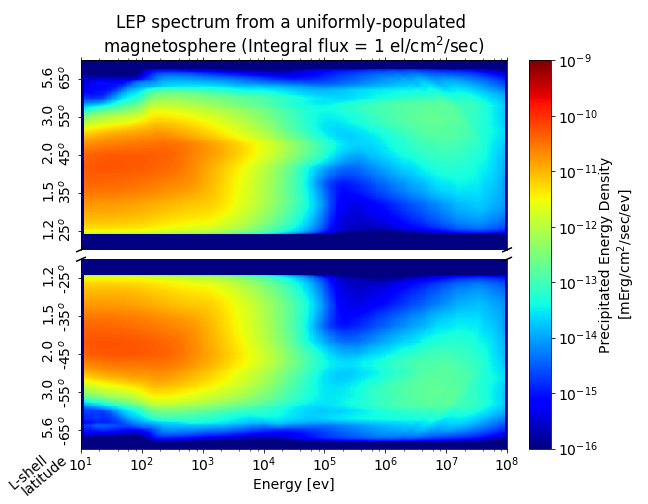

In [129]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
R2D = 180./np.pi
D2R = np.pi/180.
sec_in_year = 60*60*24*365.25
joule2millierg = 10*1e10
R_E = 6371
km2cm = 1e5

# Plot spectrum:

# energies at bin centers:
grid_E = []
for (b1, b2) in band_pairs:
    grid_E.append((E_vec[b1]+ E_vec[b2])/2.)
grid_E = np.array(grid_E)


day_index = 0

# clims = [-12,-2] # AE8 versions
clims = [-16, -9]


# Upsample the data for pretty plotting:
# pinterp = interpolate.RegularGridInterpolator((gridlats,grid_E), spec_vs_lat[:,:,day_index], bounds_error=False, fill_value=0)
pinterp = interpolate.RegularGridInterpolator((gridlats,grid_E), spec_vs_lat_avg, bounds_error=False, fill_value=0)
up_E = E_vec
up_lats = np.arange(-80,80,0.25)

px, py = np.meshgrid(up_lats, up_E, indexing='ij')
pts = zip(px.ravel(), py.ravel())
newvals = pinterp(pts)
newvals = np.reshape(newvals, [len(up_lats), len(up_E)])
newvals = np.log10(newvals)

# pdat = np.log10(spec_vs_lat[:,:,day_index])
print np.min(spec_vs_lat_avg), np.max(spec_vs_lat_avg)


fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.05])
gs.update(wspace=0.1, hspace=0.05) # set the spacing between axes.

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cax = plt.subplot(gs[:,1])

p0 = ax0.pcolormesh(up_E, up_lats, newvals, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))
p1 = ax1.pcolormesh(up_E, up_lats, newvals, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))


# p0 = ax0.pcolormesh(grid_E, gridlats, pdat, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))
# p1 = ax1.pcolormesh(grid_E, gridlats, pdat, vmin=clims[0], vmax = clims[1], cmap = plt.get_cmap('jet'))
ax0.set_xscale("log", nonposx='clip')
ax1.set_xscale("log", nonposx='clip')

cb = plt.colorbar(p0, cax=cax)
cb.set_label('Precipitated Energy Density\n[mErg/cm$^2$/sec/ev]')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)



# ---- this section to emulate the broken y-axis thing:
ax0.set_ylim([20,70])
ax1.set_ylim([-70,-20])

# ax0.set_yticks([30,45,60])
# ax1.set_yticks([-60,-45,-30])

# hide the spines between ax and ax2
ax0.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax0.xaxis.tick_top()
ax0.tick_params(labeltop='off')  # don't put tick labels at the top
ax1.xaxis.tick_bottom()

s = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((-s, +s), (-s, +s), **kwargs)        # top-left diagonal
ax0.plot((1 - s, 1 + s), (-s, +s), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-s, +s), (1 - s, 1 + s), **kwargs)  # bottom-left diagonal
ax1.plot((1 - s, 1 + s), (1 - s, 1 + s), **kwargs)  # bottom-right diagonal
# ----


ytix=np.array([25, 35, 45, 55, 65]) #ax0.get_yticks()
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
yticklabels = ['%1.1f\n%d$^o$'%(X[0],X[1]) for X in zip(ytix_L, ytix)]
ax0.set_yticks(ytix)
ax0.set_yticklabels(yticklabels,rotation=90)

ytix=np.array([-65,-55,-45, -35, -25]) #ax1.get_yticks()
ytix_L = 1.0/pow(np.cos(ytix*D2R),2)
yticklabels = ['%1.1f\n%d$^o$'%(X[0],X[1]) for X in zip(ytix_L, ytix)]
ax1.set_yticks(ytix)
ax1.set_yticklabels(yticklabels,rotation=90)

fig.subplots_adjust(right=0.85)
fig.text(0.03,0.08,"latitude",rotation=40)
fig.text(0.01,0.08,"L-shell",rotation=40)

ax1.set_xlabel('Energy [ev]')
if 'AE8MAX_flux_0' in suffix:
    ax0.set_title('Global LEP spectrum - maximum conditions')
    fig.savefig('global_LEP_spectrum_maxconds.png',dpi=150)
if 'AE8MIN_flux_0' in suffix:
    ax0.set_title('Global LEP spectrum - minimum conditions')
    fig.savefig('global_LEP_spectrum_minconds.png',dpi=150)
if 'AE8MAX_flux_2' in suffix:
    ax0.set_title('LEP spectrum from a uniformly-populated \nmagnetosphere (Integral flux = 1 el/cm$^2$/sec)')
    fig.savefig('global_LEP_spectrum_propensity.png',dpi=150)

In [20]:
# Integrate per day to get total energy deposited:
R2D = 180./np.pi
D2R = np.pi/180.
sec_in_year = 60*60*24*365.25
joule2millierg = 10*1e10
R_E = 6371
km2cm = 1e5
# Cell areas, in centimeters
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))*pow(km2cm,2.)

# Energy bin widths
dE = np.array([E_vec[p[1]] - E_vec[p[0]] for p in band_pairs])

lonlims = [-50, 10]  # ~ approximately over the US
latlims = [0, 90]
bandlims= [1e0, 1e8]

left_ind  = bisect.bisect_left(gridlons, lonlims[0])
right_ind = bisect.bisect_left(gridlons, lonlims[1])
bot_ind   = bisect.bisect_left(gridlats, latlims[0])
top_ind   = bisect.bisect_left(gridlats, latlims[1])
E_low     = bisect.bisect_left(grid_E,   bandlims[0])
E_hi      = bisect.bisect_left(grid_E,   bandlims[1])


# data: ~ Longitude, Latitude, Band, Day

# Sum over longitudes -- [mErg/cm$^2$/sec/ev]
totes = np.sum(data[left_ind:right_ind,bot_ind:top_ind,E_low:E_hi,:],axis=0)
# Integrate over latitudes -- [mErg/sec/ev]
totes = np.sum(totes*cell_areas[bot_ind:top_ind, np.newaxis, np.newaxis], axis=0)
# Integrate over energies -- [mErg/sec]
totes = np.sum(totes*dE[E_low:E_hi,np.newaxis], axis=0)
# Convert to kJ:
# kJ/sec
totes = totes*1e-3/joule2millierg

print np.min(totes), np.max(totes)

if 'AE8MAX' in suffix:
    totes_maxconds = totes
if 'AE8MIN' in suffix:
    totes_minconds = totes

0.824710483313 1795.03222248


[  5.77517689e-01   1.79230324e-02   1.28110315e+02   2.51572920e+00]


<IPython.core.display.Javascript object>


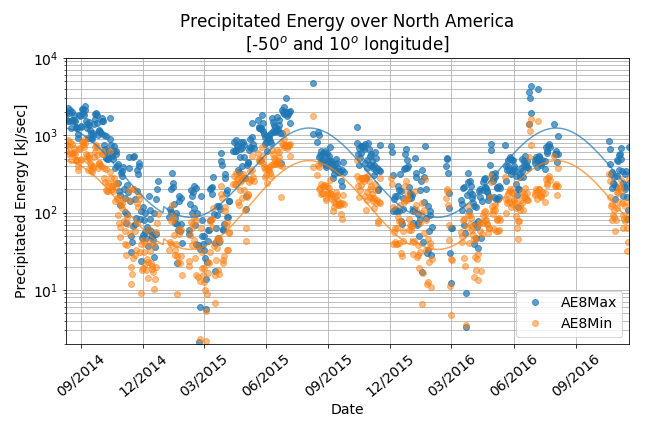

In [107]:
from dateutil.relativedelta import relativedelta

# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# Do a fit:
def func(x, a, b, c, d):
    return a*np.sin((x - c)*b) + d

doys = np.array([x.timetuple().tm_yday for x in filetimes])
popt, pcov = scipy.optimize.curve_fit(func, doys, np.log10(totes_maxconds), p0 = [1, 6.28/365., 100, 2.5])

print popt

filetimes_filled = []
doys_filled = []
x = filetimes[0]
while x < filetimes[-1]:
    filetimes_filled.append(x)
    doys_filled.append(x.timetuple().tm_yday)
    x += datetime.timedelta(days=1)

popt, pcov = scipy.optimize.curve_fit(func, doys, np.log10(totes_maxconds), p0 = [1, 6.28/365., 100, 2.5])    
fit_maxconds = pow(10,func(doys_filled, popt[0], popt[1], popt[2], popt[3]))
popt, pcov = scipy.optimize.curve_fit(func, doys, np.log10(totes_minconds), p0 = [1, 6.28/365., 100, 2.5])
fit_minconds = pow(10,func(doys_filled, popt[0], popt[1], popt[2], popt[3]))





x = datetime.datetime(2014,9,1,0,0,0)
xtix = [x]
while x < filetimes[-1]:
    x += relativedelta(months=3)
    xtix.append(x)
xticklabels = [t.strftime('%m/%Y') for t in xtix]
    
fig, ax = plt.subplots(1,1)
c0 = plt.get_cmap('Vega10')(0)
c1 = plt.get_cmap('Vega10')(1)
ax.semilogy(filetimes, totes_maxconds,'o',color=c0,alpha=0.7,label='AE8Max')
ax.semilogy(filetimes, totes_minconds,'o',color=c1,alpha=0.5,label='AE8Min')
ax.semilogy(filetimes_filled, fit_maxconds, color=c0, alpha=0.7)
ax.semilogy(filetimes_filled, fit_minconds, color=c1, alpha=0.7)

ax.grid('on',which='both')
ax.set_xticks(xtix)
ax.set_xticklabels(xticklabels, rotation=40)
ax.set_ylabel('Precipitated Energy [kJ/sec]')
ax.set_xlabel('Date')
ax.set_ylim([2e0, 1e4])
ax.set_xlim([filetimes[0], filetimes[-1]])
ax.legend()
ax.set_title('Precipitated Energy over North America\n[%d$^o$ and %d$^o$ longitude]'%(lonlims[0], lonlims[1]))
fig.tight_layout()
fig.savefig('seasonal_precip_rates.png',dpi=150)



In [122]:
# Idiot check -- integrate spec_vs_lat_avg:
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))*pow(km2cm,2.)

avg_energy = np.sum(
                    np.sum(spec_vs_lat_avg*cell_areas[:,np.newaxis],
                    axis=0)*dE)*360/dlon/joule2millierg

print "Average global energy flux: %g MJ/sec"%(avg_energy*1e-6)
         

Average global energy flux: 2.68874 MJ/sec


In [138]:
from dateutil.relativedelta import relativedelta

x = filetimes[0]
xtix = [x]

while x < filetimes[-1]:
    x += relativedelta(months=3)
    xtix.append(x)
print xtix

[datetime.datetime(2014, 8, 9, 0, 0), datetime.datetime(2014, 11, 9, 0, 0), datetime.datetime(2015, 2, 9, 0, 0), datetime.datetime(2015, 5, 9, 0, 0), datetime.datetime(2015, 8, 9, 0, 0), datetime.datetime(2015, 11, 9, 0, 0), datetime.datetime(2016, 2, 9, 0, 0), datetime.datetime(2016, 5, 9, 0, 0), datetime.datetime(2016, 8, 9, 0, 0), datetime.datetime(2016, 11, 9, 0, 0), datetime.datetime(2017, 2, 9, 0, 0)]


<IPython.core.display.Javascript object>


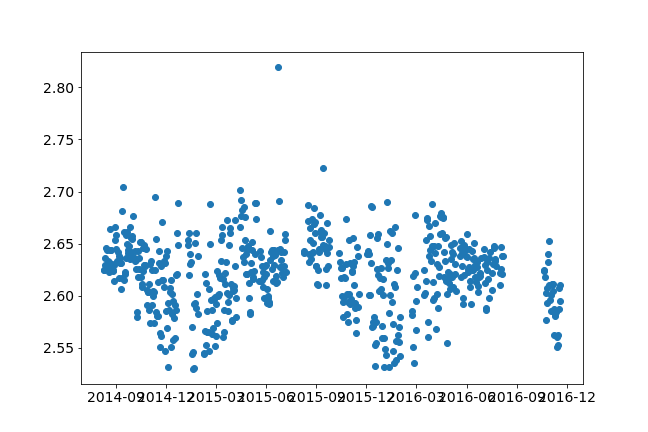

In [106]:
fig, ax = plt.subplots(1,1)
plt.plot(filetimes, totes_maxconds/totes_minconds,'o')
